### Load Modules and Set Parameters

In [1]:
# Modules
import numpy as np
import pandas as pd

import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Path Setting
DATA_IN_PATH = './txt_sim/'
DATA_OUT_PATH = './txt_sim/data_out/'
TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [3]:
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

In [4]:
# Load Data
q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE ,'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE ,'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE ,'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))


In [5]:
# Hyperparameter Setting
model_name = 'malstm_similarity'
BATCH_SIZE = 64
NUM_EPOCHS = 5
VALID_SPLIT = 0.1

kargs = {'vocab_size':prepro_configs['vocab_size'],
         'embedding_dimension':100,
         'lstm_dimension':150}

### Model Implementation

In [6]:
class MaLSTM(tf.keras.Model):
    def __init__(self, **kargs):
        super(MaLSTM, self).__init__(name=model_name)
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.lstm = layers.LSTM(units=kargs['lstm_dimension'])
    
    def call(self, x):
        x1, x2 = x
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.lstm(x1)
        x2 = self.lstm(x2)
        x = tf.exp(-tf.reduce_sum(tf.abs(x1 - x2), axis=1))
        
        return x

# number of sentences * length of each sentences -> embedding layer -> matrix = NoS * LoS * EL

### Model Compile

In [8]:
model = MaLSTM(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

### Earlystopping

In [9]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=1)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder creating completed \n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                              save_best_only=True, save_weights_only=True)

./txt_sim/data_out/malstm_similarity -- Folder creating completed 



### Model Training

In [11]:
history = model.fit((q1_data, q2_data), labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
4199/4199 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.7367
Epoch 1: val_accuracy improved from -inf to 0.81144, saving model to ./txt_sim/data_out/malstm_similarity\weights.h5
4199/4199 [==============================] - 537s 127ms/step - loss: 0.5290 - accuracy: 0.7367 - val_loss: 0.4437 - val_accuracy: 0.8114
Epoch 2/5
4199/4199 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8168
Epoch 2: val_accuracy improved from 0.81144 to 0.85810, saving model to ./txt_sim/data_out/malstm_similarity\weights.h5
4199/4199 [==============================] - 501s 119ms/step - loss: 0.4071 - accuracy: 0.8168 - val_loss: 0.3734 - val_accuracy: 0.8581
Epoch 3/5
4199/4199 [==============================] - ETA: 0s - loss: 0.3496 - accuracy: 0.8485
Epoch 3: val_accuracy did not improve from 0.85810
4199/4199 [==============================] - 499s 119ms/step - loss: 0.3496 - accuracy: 0.8485 - val_loss: 0.5508 - val_accuracy: 0.7560


### Graph for Performance

In [12]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

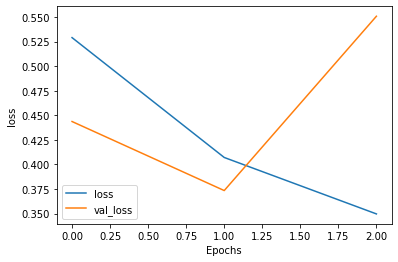

In [13]:
plot_graphs(history, 'loss')

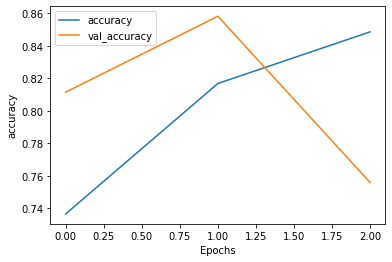

In [14]:
plot_graphs(history, 'accuracy')

### Load Test Data, Predict and Save

In [18]:
# Load Test Data
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [16]:
# Load BPM
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [19]:
# Prediction
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)

36654/36654 [==============================] - 506s 14ms/step


In [20]:
output = pd.DataFrame(data={'test_id':test_id_data, 'is_duplicate':list(predictions)})

# Save data to csv file
output.to_csv(DATA_OUT_PATH + 'LSTM_predict.csv', index=False, quoting=3)